In [1]:
## PROJECTS Unsupervised Machine Learning
## Uber Pickups

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
pio.renderers.default = "vscode"

In [3]:
#### uber-raw-data-apr14
data_01 = pd.read_csv("uber-raw-data-apr14.csv")
data_01.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [4]:
# Voir les variables avec des données vident
data_01.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

## Trie des dates 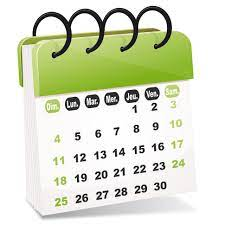

In [5]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date/Time'] = pd.to_datetime(data_01['Date/Time'])

# Extraire l'année, le mois, le jour et le jour de la semaine
data_01['Date'] = data_01['Date/Time'].dt.date
data_01['Time'] = data_01['Date/Time'].dt.time

In [6]:
# Drop la colonne Date/Time
data_01 = data_01.drop(columns = ['Date/Time'])
data_01.head()

Lat      Lon    Base        Date      Time
0  40.7690 -73.9549  B02512  2014-04-01  00:11:00
1  40.7267 -74.0345  B02512  2014-04-01  00:17:00
2  40.7316 -73.9873  B02512  2014-04-01  00:21:00
3  40.7588 -73.9776  B02512  2014-04-01  00:28:00
4  40.7594 -73.9722  B02512  2014-04-01  00:33:00

In [7]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date'] = pd.to_datetime(data_01['Date'])

# Extraire les jours de la semaine 
data_01['Dayofweek'] = data_01['Date'].dt.dayofweek
data_01.head()

Lat      Lon    Base       Date      Time  Dayofweek
0  40.7690 -73.9549  B02512 2014-04-01  00:11:00          1
1  40.7267 -74.0345  B02512 2014-04-01  00:17:00          1
2  40.7316 -73.9873  B02512 2014-04-01  00:21:00          1
3  40.7588 -73.9776  B02512 2014-04-01  00:28:00          1
4  40.7594 -73.9722  B02512 2014-04-01  00:33:00          1

In [8]:
# Voir la distribution de la nouvelle colonne "Cat"
data = data_01['Dayofweek'].value_counts()
data

Dayofweek
2    108631
1     91185
4     90303
3     85067
5     77218
0     60861
6     51251
Name: count, dtype: int64

## Trie des heures 

In [9]:
# Fonction pour attribuer une lettre en fonction de l'heure
def assign_letter(hour):
    if hour < 6:
        return 'A'
    elif hour < 12:
        return 'B'
    elif hour < 18:
        return 'C'
    else:
        return 'D'

In [10]:
# Ajout de la colonne "Cat" avec les lettres attribuées
data_01['Cat_Time'] = data_01['Time'].apply(lambda x: assign_letter(x.hour))
data_01.head()

Lat      Lon    Base       Date      Time  Dayofweek Cat_Time
0  40.7690 -73.9549  B02512 2014-04-01  00:11:00          1        A
1  40.7267 -74.0345  B02512 2014-04-01  00:17:00          1        A
2  40.7316 -73.9873  B02512 2014-04-01  00:21:00          1        A
3  40.7588 -73.9776  B02512 2014-04-01  00:28:00          1        A
4  40.7594 -73.9722  B02512 2014-04-01  00:33:00          1        A

In [11]:
# Distribution de la nouvelle colonne "Cat"
data = data_01['Cat_Time'].value_counts()
data

Cat_Time
D    206428
C    192020
B    120843
A     45225
Name: count, dtype: int64

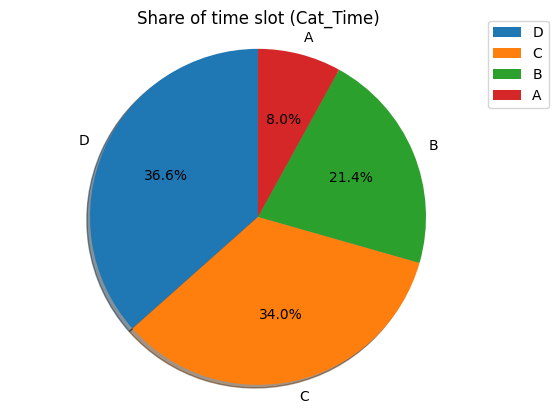

In [12]:
# Voir la distribution de la nouvelle colonne "Cat" en graphique
### "A" 00H00 / 06H00  -- "B" 06H00 / 12H00  -- "C" 12H00 / 18H00  -- "D" 18H00 / 00H00
plt.figure()
plt.pie(data.values, labels=data.index,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       radius=1.5
       )
plt.axis('equal')
plt.title('Share of time slot (Cat_Time)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [13]:
# Drop la colonne "Base", "Date", "Time"
data_01 = data_01.drop(columns = ['Base', 'Date', 'Time'])
data_01.head()

Lat      Lon  Dayofweek Cat_Time
0  40.7690 -73.9549          1        A
1  40.7267 -74.0345          1        A
2  40.7316 -73.9873          1        A
3  40.7588 -73.9776          1        A
4  40.7594 -73.9722          1        A

## Test de K-mean avec les "Dayofweek=0" soit lundi

In [14]:
# Filtrer les lignes avec Dayofweek=0 et Cat_Time='A'
data_01_lundi = data_01[(data_01['Dayofweek'] == 0)]
data_01_lundi.head()

Lat      Lon  Dayofweek Cat_Time
7785  40.7205 -73.9939          0        A
7786  40.7407 -74.0077          0        A
7787  40.7591 -73.9892          0        A
7788  40.7419 -74.0034          0        A
7789  40.7419 -74.0034          0        A

In [15]:
# Distribution de la variable data_01_filtered
data_01_lundi.shape

(60861, 4)

## Lancement de Kmean avec "data_01_lundi"

In [16]:
# Traitements
numeric_features = [0, 1] # Positions des colonnes quantitatives dans X
numeric_transformer = StandardScaler()

# Création du transformer pour les variables catégorielles
categorical_features = [2,3] # Positions des colonnes catégorielles dans X
categorical_transformer = OneHotEncoder(drop='first')

# On combine les transformers dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(data_01_lundi.head())
X_data_01_lundi = preprocessor.fit_transform(data_01_lundi) # fit_transform !!
print('...Terminé.')
print(X_data_01_lundi[0:5, :])
print()

Preprocessing sur le train set...
          Lat      Lon  Dayofweek Cat_Time
7785  40.7205 -73.9939          0        A
7786  40.7407 -74.0077          0        A
7787  40.7591 -73.9892          0        A
7788  40.7419 -74.0034          0        A
7789  40.7419 -74.0034          0        A
...Terminé.
[[-0.51941355 -0.36826967  0.          0.          0.        ]
 [ 0.00937691 -0.61130941  0.          0.          0.        ]
 [ 0.49104742 -0.28549527  0.          0.          0.        ]
 [ 0.0407902  -0.53557964  0.          0.          0.        ]
 [ 0.0407902  -0.53557964  0.          0.          0.        ]]



### Elbow method 💪

In [17]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K
# Let's use .inertia_ parameter to get the within sum of square value for each value K
wcss_data_01_lundi =  []
k_data_01_lundi = []
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(X_data_01_lundi)
    wcss_data_01_lundi.append(kmeans.inertia_)
    k_data_01_lundi.append(i)
    print("WCSS for K={} --> {}".format(i, wcss_data_01_lundi[-1]))

WCSS for K=2 --> 129041.90610604605
WCSS for K=3 --> 91919.4818206589
WCSS for K=4 --> 79038.03263133892
WCSS for K=5 --> 66943.37912762928
WCSS for K=6 --> 58922.7115485962
WCSS for K=7 --> 47963.17480115508
WCSS for K=8 --> 43283.31039469036
WCSS for K=9 --> 39053.2966380318
WCSS for K=10 --> 34659.05789793715


In [18]:
# Create DataFrame
wcss_frame_lundi = pd.DataFrame(wcss_data_01_lundi)
k_frame_lundi = pd.Series(k_data_01_lundi)

# Create figure
fig= px.line(
    wcss_frame_lundi,
    x=k_frame_lundi,
    y=wcss_frame_lundi.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

## Silhouette 👥

In [19]:
# Computer mean silhouette score
sil_lundi = []
k_lundi = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels
# Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels
for i in range(2, 11):
    kmeans_lundi = KMeans(n_clusters=i, random_state=0, n_init='auto')
    kmeans_lundi.fit(X_data_01_lundi)
    sil_score = silhouette_score(X_data_01_lundi, kmeans_lundi.labels_)
    sil_lundi.append(sil_score)
    k_lundi.append(i)
    print("Silhouette score for K={} is {}".format(i, sil_score))

Silhouette score for K=2 is 0.24264246412521315
Silhouette score for K=3 is 0.25581508501321276
Silhouette score for K=4 is 0.3106886501846734
Silhouette score for K=5 is 0.39233925132807196
Silhouette score for K=6 is 0.4225013516819768
Silhouette score for K=7 is 0.4465308281762267
Silhouette score for K=8 is 0.4502214890284539
Silhouette score for K=9 is 0.42625140210258095
Silhouette score for K=10 is 0.42437422430709065


In [34]:
# Create a data frame
cluster_scores_lundi=pd.DataFrame(sil_lundi)
k_frame_lundi = pd.Series(k_lundi)

# Create figure
fig = px.bar(data_frame=cluster_scores_lundi,
             x=k_lundi,
             y=cluster_scores_lundi.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

In [35]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters= 3, n_init = "auto")
kmeans.fit(X_data_01_lundi)

KMeans(n_clusters=3, n_init='auto')

In [36]:
# Création d'une copie du DataFrame
data_01_lundi_kmeans = data_01_lundi.copy()

In [37]:
# Ajout de la colonne "Cluster_KMeans" dans le Dataframe "data_01_filtered"
data_01_lundi_kmeans.loc[:, 'Cluster_KMeans'] = kmeans.labels_

In [38]:
# Voir le nouveau dataframe
data_01_lundi_kmeans.head()

Lat      Lon  Dayofweek Cat_Time  Cluster_KMeans
7785  40.7205 -73.9939          0        A               0
7786  40.7407 -74.0077          0        A               0
7787  40.7591 -73.9892          0        A               1
7788  40.7419 -74.0034          0        A               0
7789  40.7419 -74.0034          0        A               0

In [39]:
# Distribution de la nouvelle colonne "Cat" pour le lundi du moi d'avril 
data_lundi = data_01_lundi_kmeans['Cat_Time'].value_counts()
data_lundi

Cat_Time
C    21710
D    18830
B    16093
A     4228
Name: count, dtype: int64

In [40]:
# Voir la distribution de la nouvelle colonne "Cat" en graphique
### "A" 00H00 / 06H00  -- "B" 06H00 / 12H00  -- "C" 12H00 / 18H00  -- "D" 18H00 / 00H00
plt.figure()
plt.pie(data_lundi.values, labels=data_lundi.index,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       radius=1.5
       )
plt.axis('equal')
plt.title('Share of time slot on Monday (Cat_Time)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [41]:
# On utilise scatter_mapbox pour visualiser notre graphique
fig = px.scatter_mapbox(data_frame=data_01_lundi_kmeans, lat='Lat', lon='Lon', color='Cluster_KMeans', mapbox_style="carto-positron")
fig.show()

## Lancement de DBScan avec "data_01_lundi"

In [42]:
eps = 1.0  # Ajustez ce paramètre en fonction de la densité de vos données
min_samples = 12  # Ajustez ce paramètre en fonction de la densité de vos données

db_lundi = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
db_lundi.fit(X_data_01_lundi)

DBSCAN(eps=1.0, min_samples=12)

In [43]:
# Création d'une copie du DataFrame
data_01_lundi_dbscan = data_01_lundi_kmeans.copy()

In [44]:
# Afficher combien de clusters DBSCAN a créés
np.unique(db_lundi.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [45]:
# Création de la colonne "Cluster_DBSCAN"
data_01_lundi_dbscan["Cluster_DBSCAN"] = db_lundi.labels_

In [46]:
# Voir le nouveau dataframe
data_01_lundi_dbscan.head()

Lat      Lon  Dayofweek Cat_Time  Cluster_KMeans  Cluster_DBSCAN
7785  40.7205 -73.9939          0        A               0               0
7786  40.7407 -74.0077          0        A               0               0
7787  40.7591 -73.9892          0        A               1               0
7788  40.7419 -74.0034          0        A               0               0
7789  40.7419 -74.0034          0        A               0               0

In [47]:
# Visualiser les Clusters
fig = px.scatter_mapbox(
        data_01_lundi_dbscan[data_01_lundi_dbscan.Cluster_DBSCAN != -1],
        lat="Lat",
        lon="Lon",
        color="Cluster_DBSCAN",
        mapbox_style="carto-positron"
)

fig.show()